# Face Landmarks

Using a subset of [UMD Faces](http://umdfaces.io) database to train a face landmarks predicting model.

In [1]:
from functools import partial
from multiprocessing import Pool
from os.path import join
from pathlib import Path
import random
import math

In [2]:
import pandas as pd
import numpy as np
import cv2 as cv
import PIL.Image
from imageio import imread
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tqdm import tqdm_notebook as tqdm

In [3]:
import fastai
from fastai import defaults
from fastai.vision import open_image
from fastai.callbacks import (
    EarlyStoppingCallback, 
    SaveModelCallback, 
    ReduceLROnPlateauCallback,
    CSVLogger)

from torch.utils.data import Dataset
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms as T
from torchvision.transforms.functional import to_tensor, to_pil_image

In [4]:
SEED = 1
DEVICE = torch.device('cuda:1')
random.seed(SEED)
torch.manual_seed(SEED)
defaults.device = DEVICE

---
## Dataset First Glance

In [5]:
ROOT = Path.home()/'data'/'umdfaces'/'batch3'
META = ROOT/'umdfaces_batch3_ultraface.csv'
NUM_LANDMARKS = 42

In [6]:
meta = pd.read_csv(META)
meta.columns = meta.columns.str.lower()

In [7]:
cols = meta.columns
file_cols = ['subject_id', 'file']
face_cols = cols[cols.str.startswith('face')].tolist()
x_cols = cols[cols.str.startswith('p') & cols.str.endswith('x')].tolist()
y_cols = cols[cols.str.startswith('p') & cols.str.endswith('y')].tolist()

In [8]:
faces_df = meta[file_cols + face_cols + x_cols + y_cols]
faces_df.head()

,subject_id,file,face_x,face_y,face_width,face_height,p1x,p2x,p3x,p4x,...,p12y,p13y,p14y,p15y,p16y,p17y,p18y,p19y,p20y,p21y
0,1,andrew_j_feustel/andrew_j_feustel_0001.jpg,396.10470,115.99280,55.28760,53.28240,406.4610,411.5070,417.1110,428.6170,...,127.0370,140.5620,138.0710,138.8910,138.602,142.3300,147.6620,149.1460,148.159,164.835
1,1,andrew_j_feustel/andrew_j_feustel_0002.jpg,808.97000,218.05190,51.22800,49.00920,814.2580,818.2730,823.3880,834.2550,...,227.0650,245.2970,239.5190,238.9180,238.428,240.4170,248.7770,248.6390,246.979,262.977
2,1,andrew_j_feustel/andrew_j_feustel_0003.jpg,116.16960,82.37583,54.30480,56.21364,120.6950,122.2240,125.1790,132.0140,...,94.0531,110.1360,109.3490,106.9300,108.483,111.0730,119.6780,118.6960,118.978,133.905
3,1,andrew_j_feustel/andrew_j_feustel_0004.jpg,483.74100,213.87210,320.85600,313.16280,552.0410,587.0870,625.0260,693.3090,...,273.0160,350.0050,345.9300,352.6960,347.401,353.7210,402.4170,410.8210,402.350,500.938
4,1,andrew_j_feustel/andrew_j_feustel_0005.jpg,19.08284,52.63863,65.63352,64.68804,30.0739,36.4028,43.5955,58.0033,...,65.4809,83.2004,79.2413,80.0437,79.606,84.1834,91.0663,92.6855,91.236,111.936


In [9]:
def show(i, ax=None):
    global faces_df, ROOT
    r = faces_df.loc[i]
    img = imread(ROOT/r.file)
    x_pts = [r[k] for k in r.keys() if k[0] == 'p' and k[-1] == 'x']
    y_pts = [r[k] for k in r.keys() if k[0] == 'p' and k[-1] == 'y']
    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=(8, 8))
    rc = Rectangle(xy=(r.face_x, r.face_y), 
                   width=r.face_width, height=r.face_height,
                   edgecolor='red', fill=False, lw=5)
    ax.imshow(img)
    ax.scatter(x_pts, y_pts, edgecolor='white', color='lightgreen', alpha=0.8)    
    ax.add_patch(rc)

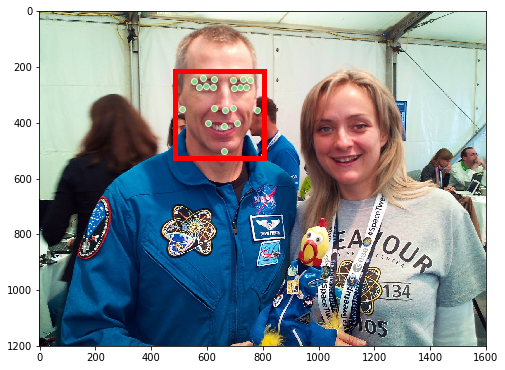

In [10]:
show(3)

In [11]:
def show_grid(n=3):
    global faces_df
    f, axes = plt.subplots(n, n, figsize=(12, 12))
    indicies = np.random.choice(len(faces_df), n ** 2, replace=False)
    for i, ax in zip(indicies, axes.flat):
        show(i, ax=ax)
        ax.set_axis_off()

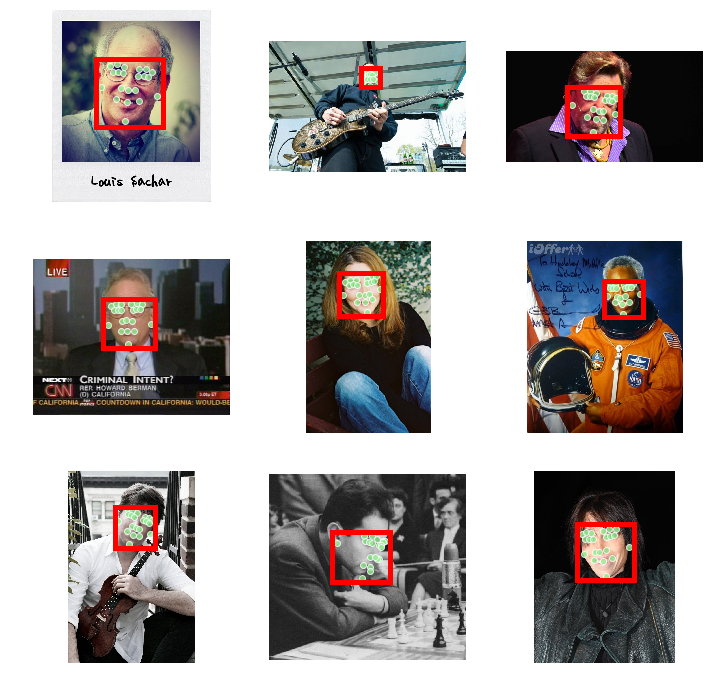

In [12]:
show_grid()

Ok, it seems that each sample includes (at least) one human in various poses with various backgrounds. Therefore, our first goal is to convert this dataset into a more suitable format before we processed with training the model. The most straightforward way to do so is to _crop_ the faces only and save them into smaller files.

In [13]:
def create_face_landmarks_dataset(
    root: Path,
    faces_info: pd.DataFrame,
    output: Path
):
    if output.exists():
        print(f'The data is already prepared. Reading from folder: {output}')
        images = [str(x) for x in read_ordered_files(output, '*.jpeg')]
        points = [str(x) for x in read_ordered_files(output, '*.txt')]
        if not images or not points:
            print('Warning: no files in output folder! Delete the folder and try again')
        data = pd.DataFrame({'image': images, 'points': points})
        
    else:
        output.mkdir(parents=True)
        print(f'Saving output into folder: {output}')
        cols = faces_info.columns
        records = [{
            'subject_id': r.subject_id,
            'input_path': root/r.file,
            'output_image': output/f'{i}.jpeg',
            'output_points': output/f'{i}.txt',
            'x_pos': [r[k] for k in r.keys() if k[0] == 'p' and k[-1] == 'x'],
            'y_pos': [r[k] for k in r.keys() if k[0] == 'p' and k[-1] == 'y'],
            'face': (r.face_x, r.face_y, r.face_width, r.face_height)
        } for i, r in faces_info.iterrows()]

        print(f'Number of records to process: {len(records)}')
        with Pool() as pool:
            results = pool.map(crop_and_save, records)
        data = pd.DataFrame(results)
    
    data['order'] = data.image.map(lambda s: int(Path(s).stem))
    data.sort_values(by='order', inplace=True)
    return data
        
    
def read_ordered_files(path, pattern):
    return list(sorted([fn for fn in path.glob(pattern)], key=lambda filename: int(filename.stem)))    


def split(arr):
    return arr[:NUM_LANDMARKS//2], arr[NUM_LANDMARKS//2:]


def to_centered(xs, ys, w, h):
    return 2*xs/w - 1, 2*ys/h - 1


def to_absolute(xs, ys, w, h):
    return w*(xs + 1)/2., h*(ys + 1)/2. 

    
def crop_and_save(record):
    x, y, w, h = record['face']
    img = PIL.Image.open(record['input_path'])
    cropped = img.crop(box=(x, y, x+w, y+h))
    x_pos, y_pos = [np.array(record[k]) for k in ('x_pos', 'y_pos')]
    x_pos, y_pos = to_centered(x_pos - x, y_pos - y, w, h)
    cropped.save(record['output_image'], format='jpeg')
    np.savetxt(record['output_points'], np.c_[x_pos, y_pos], fmt='%.4f', delimiter=',')
    return {'image': str(record['output_image']), 'points': str(record['output_points'])}

In [14]:
landmarks_df = create_face_landmarks_dataset(ROOT, faces_df, ROOT.parent/'prepared')

The data is already prepared. Reading from folder: /home/ck/data/umdfaces/prepared


In [15]:
def show(df, i, ax=None):
    record = df.loc[i]
    show_image(record.image, record.points, create_axis(ax))

    
def create_axis(ax=None, size=6):
    if not ax:
        if isinstance(size, int):
            size = (size, size)
        f, ax = plt.subplots(1, 1, figsize=size)
    return ax
    
    
def show_image(image, points, ax):
    if isinstance(image, str):
        image = imread(image)
    if isinstance(points, str):
        points = np.loadtxt(points, delimiter=',')
    points = points.reshape(NUM_LANDMARKS//2, 2)
    h, w = image.shape[:2]
    xs, ys = to_absolute(points[:, 0], points[:, 1], w, h)
    ax.imshow(image)
    ax.scatter(xs, ys, edgecolor='white', color='lightgreen', alpha=0.8)
    ax.set_axis_off()
    
    
def show_grid(df, n=3):
    f, axes = plt.subplots(n, n, figsize=(10, 10))
    indicies = np.random.choice(len(df), n ** 2, replace=False)
    for i, ax in zip(indicies, axes.flat):
        show(df, i, ax=ax)

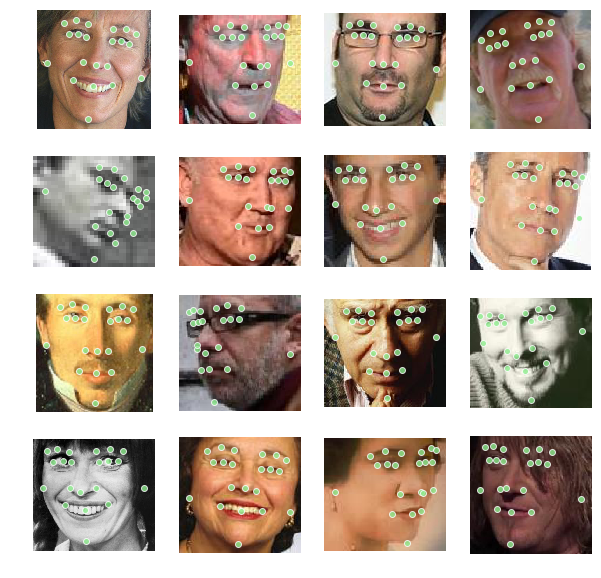

In [16]:
show_grid(landmarks_df, 4)

---
## Custom Dataset Class

In [17]:
class FaceLandmarks(Dataset):
    
    def __init__(self, data, indicies=None, transforms=None):
        if indicies is not None:
            data = data.loc[indicies]
        
        self.images = [str(x) for x in data.image]
        self.points = [str(x) for x in data.points]
        self.transforms = transforms
    
    def __getitem__(self, item):
        img = imread(self.images[item])
        pts = np.loadtxt(self.points[item], delimiter=',')
        cat = np.r_[pts[:, 0], pts[:, 1]]
        if self.transforms is not None:
            img, cat = self.transforms(img, cat)
        return img, cat
    
    def __len__(self):
        return len(self.images)
    
    def show(self, i):
        show_image(self.images[i], self.points[i], create_axis(size=4))

    @property
    def c(self):
        return NUM_LANDMARKS

In [18]:
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return t

In [19]:
landmarks_df = create_face_landmarks_dataset(ROOT, faces_df, ROOT.parent/'prepared')

The data is already prepared. Reading from folder: /home/ck/data/umdfaces/prepared


In [20]:
n = len(landmarks_df)

In [21]:
trn_idx, val_idx = train_test_split(np.arange(n), test_size=0.1)

In [22]:
trn_ds = FaceLandmarks(landmarks_df, indicies=trn_idx)
val_ds = FaceLandmarks(landmarks_df, indicies=val_idx)

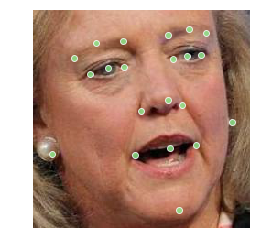

In [23]:
trn_ds.show(0)

In [24]:
mean, n = None, 1
trn_size = len(trn_ds)
with tqdm(total=trn_size) as bar:
    for i in range(trn_size):
        _, landmarks = trn_ds[i]
        if mean is None:
            mean = landmarks
        else:
            mean = (1./n)*(landmarks + (n - 1)*mean)
        bar.update()
        n += 1

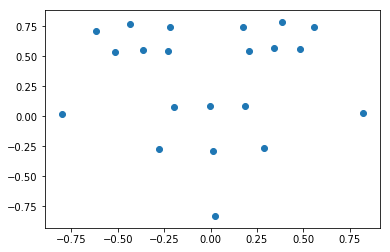

In [25]:
xs, ys = split(mean)
plt.scatter(xs, -ys)

In [26]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

In [27]:
Flatten()(torch.tensor([[
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
]])).shape

torch.Size([1, 9])

In [ ]:
class FEC(nn.Module):
    
    def __init__(self, s0, patch_size=10):
        super().__init__()
        self.s0 = s0
        self.patch_size = patch_size
        self.upsample = nn.UpsamplingBilinear2d()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=6, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = Flatten()
        self.fc1 = nn.Linear(128, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, NUM_LANDMARKS)
        
    def forward(self, image):
        breakpoint()
        h, w = image.shape[-2:]
        xs, ys = split(self.s0)
        xs, ys = to_absolute(xs, ys, h, w)
        xs, ys = xs.astype(int), ys.astype(int)
        
        breakpoint()

        p = self.patch_size
        features = []
        
        for x, y in zip(xs, ys):
            patch = image[y-p:y+p, x-p,x+p]
            
            t = self.conv1(patch)
            t = self.bn1(t)
            t = F.relu(t)
            t = self.pool1(t)
            
            t = self.conv2(t)
            t = self.bn2(t)
            t = F.relu(t)
            t = self.pool2(t)
            
            t = self.flatten(t)
            t = self.fc1(t)
            t = self.bn3(t)
            t = F.relu(t)
            
            features.append(t)
        
        cat = torch.cat(features)
        return self.fc2(cat)        

In [ ]:
fec = FEC(mean, 10)

In [ ]:
fec(to_tensor(trn_ds[0][0]))

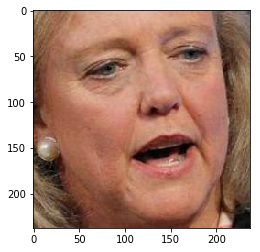

In [30]:
plt.imshow(trn_ds[0][0])

---
## Augmentations

In [ ]:
from inspect import signature

In [ ]:
def binomial():
    return np.random.rand()

In [ ]:
class Resize:
    
    def __init__(self, size):
        self.size = (size, size) if isinstance(size, int) else size
        
    def __call__(self, image):
        return cv.resize(image, self.size, cv.INTER_NEAREST)

In [ ]:
class Rotate:
    
    def __init__(self, angle=5):
        self.minmax = (-angle, angle) if isinstance(angle, int) else angle
    
    def __call__(self, image, target=None):
        h, w = image.shape[:2]
        angle = np.random.uniform(*self.minmax)
        m = cv.getRotationMatrix2D((w/2, h/2), angle, 1)
        image = cv.warpAffine(image, m, (w, h))
        
        if target is not None:
            new_target = np.copy(target)
            n = target.shape[0] // 2
            for i in range(n):
                new_target[i] = m[0][0]*target[i] + m[0][1]*target[i + n]
                new_target[i + n] = m[1][0]*target[i] + m[1][1]*target[i + n]
            target = new_target
        
        return image, target

In [ ]:
class Shift:
    
    def __init__(self, shift=0.01):
        self.minmax = (shift, shift) if isinstance(shift, float) else shift
    
    def __call__(self, image, target=None):
        h, w = image.shape[:2]
        sx, sy  = self.minmax
        shift_x = np.random.randint(-w*sx, w*sx)
        shift_y = np.random.randint(-h*sy, h*sy)
        m = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
        image = cv.warpAffine(image, m, (w, h))
        
        if target is not None:
            new_target = np.copy(target)
            half = target.shape[0] // 2
            last = target.shape[0]
            new_target[0:half] = target[0:half] + shift_x/(w/2)
            new_target[half:last] = target[half:last] + shift_y/(h/2)
            target = new_target
        
        return image, target

In [ ]:
def horizontal_flip(image, target=None):
    if target is not None:
        new_target = np.copy(target)
        half = target.shape[0] // 2
        new_target[0:half] *= -1
        target = new_target
    
    return np.fliplr(image), target

In [ ]:
class ChangeIllumination:
    
    def __init__(self, min_alpha=0.8, max_alpha=1.1, delta=0.8):
        self.min_alpha = min_alpha
        self.max_alpha = max_alpha
        self.delta = delta
        
    def __call__(self, image, target=None):
        alpha = np.random.uniform(self.min_alpha, self.max_alpha)
        mean = np.mean(image)
        image = self.delta*image + (1 - self.delta)*mean
        image *= alpha
        return image, target

In [ ]:
def contiguous(image):
    return np.ascontiguousarray(image)

In [ ]:
def expand_channels(image):
    if len(image.shape) == 2:
        image = np.stack((image,)*3, axis=-1)
    return image

In [ ]:
def to_xy_tensors(image, target):
    return (
        torch.FloatTensor(image).permute(2, 0, 1),
        torch.FloatTensor(target)
    )

In [ ]:
class RandomTargetCompose:
    """Similar to transforms.Compose but optionally passes an additional 
    `target` parameter into transformation callables and applies 
    transformations randomly.
    """
    def __init__(self, transforms):
        self.transforms = transforms
        
    def __call__(self, image, target=None):
        for t in self.transforms:
            if isinstance(t, tuple):
                rand, t = t
                if binomial() > rand:
                    continue
            params = signature(t).parameters
            if 'target' in params:
                image, target = t(image, target)
            else:
                image = t(image)
        return image, target

In [ ]:
aug = RandomTargetCompose([
    (1.0, Rotate(angle=(-10, 10))),
    (1.0, Shift(shift=0.05)),
    (0.8, ChangeIllumination()),
    (0.5, horizontal_flip),
])

In [ ]:
trn_ds = FaceLandmarks(landmarks_df, indicies=trn_idx, transforms=aug)

In [ ]:
test_img, test_pts = trn_ds[0]
h, w = test_img.shape[:2]
n = len(test_pts)
xs, ys = test_pts[:n//2], test_pts[n//2:]
xs = w*(xs + 1)/2
ys = h*(ys + 1)/2
f, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(test_img.astype('uint8'))
ax.scatter(xs, ys)
print(test_img.shape)
print(test_pts.shape)
print('Range:', test_img.min(), test_img.max())

In [ ]:
from fastai import Learner, DatasetType, to_np
from fastai.vision import ImageDataBunch, imagenet_stats, create_cnn, imagenet_stats
from torchvision import models
from torchvision.transforms.functional import to_tensor

In [ ]:
trn_aug = RandomTargetCompose([
    Resize(224),
    (0.5, Rotate(angle=(-15, 10))),
    (0.5, Shift(shift=0.05)),
    (0.5, ChangeIllumination()),
    (0.5, horizontal_flip),
    expand_channels,
    contiguous,
    to_xy_tensors,
    T.Normalize(*imagenet_stats)
])

val_aug = RandomTargetCompose([
    Resize(224),
    expand_channels,
    contiguous,
    to_xy_tensors,
    T.Normalize(*imagenet_stats)
])

trn_ds = FaceLandmarks(landmarks_df, indicies=trn_idx, transforms=trn_aug)
val_ds = FaceLandmarks(landmarks_df, indicies=val_idx, transforms=val_aug)
bunch = ImageDataBunch.create(trn_ds, val_ds, bs=64, num_workers=12)
bunch.train_ds[0][0].shape

In [ ]:
path = ROOT.parent/'tmp'
path

In [ ]:
learn = create_cnn(bunch, models.resnet50, path=path, loss_func=F.mse_loss)

In [ ]:
def predict(model, dataset, i, j=None):
    model.train(False)
    if j is not None:
        j = max(j, i + 1)
        batch = torch.stack([dataset[idx][0] for idx in range(i, j)])
    else:
        batch = dataset[i][0][None]
    preds = model(batch.to(DEVICE))
    model.train(True)
    return preds

In [ ]:
def show_predictions(model, dataset, i, j=None):
    batch = predict(model, dataset, i, j)
    n = int(math.sqrt(j - i))
    m = (j - i) // n
    images = [imread(dataset.images[idx]) for idx in range(i, j)]
    f, axes = plt.subplots(n, m, figsize=(10, 10))
    for img, pts, ax in zip(images, to_np(batch), axes.flat):
        h, w = img.shape[:2]
        xs, ys = pts[:NUM_LANDMARKS//2], pts[NUM_LANDMARKS//2:]
        xs = w*(xs + 1)/2.
        ys = h*(ys + 1)/2.
        ax.imshow(img)
        ax.scatter(xs, ys, color='lightgreen', edgecolor='white', alpha=0.8, s=30)
        ax.set_axis_off()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
cb = [
    EarlyStoppingCallback(learn, patience=3),
    Save]
learn.fit_one_cycle(10, max_lr=5e-3, wd=1e-2, callbacks=cb)

In [ ]:
show_predictions(learn.model, val_ds, 0, 9)

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 5e-06
cb = [EarlyStoppingCallback(learn, patience=5)]
learn.fit_one_cycle(20, max_lr=[lr/10, lr/3, lr], wd=1e-4, callbacks=cb)

In [ ]:
show_predictions(learn.model, val_ds, 32, 48)

In [ ]:
# img = imread(val_ds.images[0])
# pts = np.loadtxt(val_ds.points[0], delimiter=',')
# h, w = img.shape[:2]
# xs, ys = pts[:, 0], pts[:, 1]
# xs, ys = to_absolute(xs, ys, w, h)
# pts1 = np.float32([[0,0],[w,0],[0, h],[w,h]])
# pts2 = np.float32([[0,0],[w,0],[0,h],[w,h/2]])
# m = cv.getPerspectiveTransform(pts1,pts2)
# img = cv.warpPerspective(img, m, img.shape[:2])
# for i in range(NUM_LANDMARKS//2):
#     xs[i] = (m[0][0]*xs[i] + m[0][1]*ys[i] + m[0][2])/m[]
#     ys[i] = m[1][0]*xs[i] + m[1][1]*ys[i] + m[1][2]
# f, ax = plt.subplots(1, 1)
# ax.imshow(img)
# ax.scatter(xs, ys)